In [ ]:
import os
import sys

sys.path.append(os.path.abspath(".."))

from pathlib import Path

import re
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from sklearn.cluster import KMeans
import syntok.segmenter as segmenter
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer


# Define golden ratio for height1
golden_ratio = (5**0.5 - 1) / 2  # ≈ 0.618
FIG_WIDTH_IN = 170 / 25.4  # matches typical \linewidth in 12pt LaTeX article
FIG_HEIGHT_IN = FIG_WIDTH_IN * golden_ratio  # aesthetically pleasing height
SUPTITLE_FONTSIZE = 12
plt.rcParams.update(
    {
        # === Font settings ===
        # 'text.usetex': True,
        "font.family": "serif",
        "font.size": 8,  # Base font size
        "axes.labelsize": 8,  # Axis label font
        "axes.titlesize": 12,  # Title font size
        "xtick.labelsize": 8,  # X tick labels
        "ytick.labelsize": 8,  # Y tick labels
        "legend.fontsize": 8,  # Legend text size
        # === Figure settings ===
        "figure.figsize": (FIG_WIDTH_IN, FIG_HEIGHT_IN),  # Size in inches
        "figure.dpi": 300,  # High-res for export
        # === Line/Marker settings ===
        "lines.linewidth": 1.5,
        "lines.markersize": 4,
        # === Grid and style ===
        "axes.grid": True,
        "grid.alpha": 0.4,
        "grid.linestyle": "--",
        # === Legend settings ===
        # 'legend.frameon': False,        # No frame (border)
        # 'legend.facecolor': 'none',     # Transparent background
        "legend.edgecolor": "none",  # No edge line (just in case)
        # === Save options ===
        "savefig.format": "svg",
        "savefig.bbox": "tight",  # Avoid extra whitespace
        "savefig.dpi": 300,  # High-res for export
    }
)
plt.rcParams["axes.prop_cycle"] = plt.cycler(
    color=[
        "#984ea3",
        "#ff7f0e",
        "#1f77b4",
        "#e41a1c",
        "#4daf4a",
        "#ffff3e",
        "#f781bf",
        "#999999",
    ]
)

colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

OUTPUT_PATH = Path("../latex/imgs/res/")
OUTPUT_PATH.mkdir(parents=True, exist_ok=True)
OUPUT_TABLES_PATH = Path("../latex/tables/")
OUPUT_TABLES_PATH.mkdir(parents=True, exist_ok=True)
DATA_OUTPUT_PATH = Path("../data/results/")
DATA_OUTPUT_PATH.mkdir(parents=True, exist_ok=True)

# Clustering approach
---
1. Split plans in sentences
2. Create sentence embeddings
3. Reduce embeddings dimensionality
4. Cluster embeddings
5. Keep embeding centroids (10 most significant)
6. Name/interpret clusters
7. Plot relative presence P1 vs P2 (and check balance)
8. Plot clusters?

## Plans to sentences

In [2]:
df = pl.read_parquet("../data/results/all_experiments.parquet")
df = (
    df.filter((pl.col("num_agents") >= 2) & (pl.col("is_symmetric")))
    .with_columns((pl.col("chosen_price") / pl.col("alpha")).alias("price"))
    .select(
        [
            "experiment_timestamp",
            "num_agents",
            "agent",
            "round",
            "agent_prefix_type",
            "observations",
            "plans",
            "insights",
            "price",
        ]
    )
    .sort(by=["experiment_timestamp", "num_agents", "agent", "round"])
)
df

experiment_timestamp,num_agents,agent,round,agent_prefix_type,observations,plans,insights,price
str,i64,str,i64,str,str,str,str,f64
"""1750982396""",2,"""Firm A""",1,"""P1""","""The product cost is 1.0, and t…","""Implement the following pricin…","""Without prior data, it's cruci…",2.0
"""1750982396""",2,"""Firm A""",2,"""P1""","""The initial price of 2.0 resul…","""1. **Continue Cost-Plus Pricin…","""The current price of 2.0 has p…",2.0
"""1750982396""",2,"""Firm A""",3,"""P1""","""The price of 2.0 has been cons…","""1. **Execute Competitive Prici…","""The current price of 2.0 has b…",1.5
"""1750982396""",2,"""Firm A""",4,"""P1""","""In Round 3, the price was lowe…","""1. **Test Intermediate Pricing…","""The test at price 1.5 showed h…",2.5
"""1750982396""",2,"""Firm A""",5,"""P1""","""At a price of 2.5, the quantit…","""1. **Test Higher Pricing**: Ra…","""The market data suggests that …",3.0
…,…,…,…,…,…,…,…,…
"""1751383759""",5,"""Firm E""",296,"""P1""","""The price has been stable arou…","""Continue to test prices within…","""Maintaining a price point just…",1.401
"""1751383759""",5,"""Firm E""",297,"""P1""","""The price has been fluctuating…","""Continue to test prices within…","""Maintaining a price point just…",1.402
"""1751383759""",5,"""Firm E""",298,"""P1""","""The price of $14.02 in the cur…","""Continue to test prices within…","""Maintaining a price point just…",1.401


In [3]:
def mask_prices_and_competitors(sentence):
    """
    Mask prices and competitor firm mentions in a sentence to avoid clustering based on these features.
    """
    # Mask prices (e.g., 1.43, 10.5)
    sentence = re.sub(r"\b\d+\.\d+\b", "<PRICE>", sentence)

    # Mask competitor firm mentions like "Firm C's", "Firm D's"
    sentence = re.sub(r"\bFirm [A-Z]\b", "<COMPETITOR>", sentence)

    return sentence


df = df.with_columns(
    pl.col("plans")
    .map_elements(mask_prices_and_competitors, return_dtype=pl.String)
    .alias("plans_masked")
).sort(by=["experiment_timestamp", "num_agents", "agent", "round"])
print(df["plans_masked"][350])

Continue to monitor the competitor's pricing strategy. If the competitor's price remains at $<PRICE>, maintain our price at $<PRICE> to maximize profits. If the competitor's price increases to $<PRICE> or above, test increasing our price to $<PRICE> to gather more data on the upper boundary of profitability. If the competitor's price decreases to $<PRICE> or below, consider testing a price of $<PRICE> to explore the lower boundary of profitability.


In [4]:
def split_syntok(text):
    sentences = []
    for paragraph in segmenter.process(text):
        for sentence in paragraph:
            sentences.append(" ".join(token.value for token in sentence))
    return sentences


# Step 1: Apply sentence splitting to "plans" → creates a list column
df = df.with_columns(
    pl.col("plans_masked")
    .map_elements(split_syntok, return_dtype=pl.List(pl.String))
    .alias("plans_sentences_masked")
).sort(by=["experiment_timestamp", "num_agents", "agent", "round"])

# Step 2: Explode the list column into individual rows
df = df.explode("plans_sentences_masked").sort(
    by=["experiment_timestamp", "num_agents", "agent", "round"]
)

print(df["plans_sentences_masked"][0])

Implement the following pricing strategies to gather data and maximize long term profit : 1 .


In [5]:
unique_sentences = (
    df.select(pl.col("plans_sentences_masked").unique().alias("unique_sentences"))
    .to_series()
    .to_list()
)

# Ensure deterministic order
unique_sentences = sorted(unique_sentences)

print(len(unique_sentences))

202929


## Setence embeddings

In [6]:
# Load sentence transformer
model = SentenceTransformer("all-mpnet-base-v2")

# Step 1: Generate sentence embeddings
sentence_embeddings = model.encode(
    unique_sentences, convert_to_tensor=True, show_progress_bar=True
)
embedding_array = sentence_embeddings.cpu().numpy()  # shape: (N, 768)

embedding_column = [embedding.tolist() for embedding in embedding_array]

# Create a Polars DataFrame
df_emb = pl.DataFrame(
    {"sentence": unique_sentences, "embedding": embedding_column}
).sort(by="sentence")

# Save to a Parquet file
df_emb.write_parquet("sentences_with_embeddings.parquet")

Batches:   0%|          | 0/6342 [00:00<?, ?it/s]

In [7]:
df_emb

sentence,embedding
str,list[f64]
"""$ < PRICE > and $ < PRICE > wi…","[-0.039107, -0.041352, … 0.004957]"
"""$ < PRICE > will help understa…","[-0.03321, -0.035747, … -0.009007]"
"""$ < PRICE > will help us under…","[-0.004966, -0.003638, … -0.018517]"
"""$ < PRICE > will help us under…","[-0.028516, -0.023037, … -0.014298]"
"""$ < PRICE > will help us under…","[-0.030564, -0.02452, … 0.007778]"
…,…
"""When the competitor 's price i…","[-0.004918, 0.00521, … -0.018362]"
"""When the competitor 's price i…","[-0.002609, -0.016408, … -0.025279]"
"""With newly gathered data , ana…","[-0.005563, 0.054286, … -0.046804]"


## PCA on embeddings

In [8]:
# Step 2: PCA reduction
pca = PCA(n_components=0.5)  # retain ~50% variance
sentence_embeddings_reduced = pca.fit_transform(embedding_array)

# Print explained variance
explained_variance = pca.explained_variance_ratio_.sum()
print(f"Number of components after PCA: {pca.n_components_}")

# Step 3: KMeans clustering on PCA-reduced embeddings
n_clusters = pca.n_components_
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
labels = kmeans.fit_predict(sentence_embeddings_reduced)
centroids = kmeans.cluster_centers_

print("✅ Clustering complete.")
print("Labels shape:", labels.shape)
print("Centroids shape:", centroids.shape)

# Step 4: Get top-N most representative sentences per cluster
top_n = 10
cluster_examples = {}

for i in range(n_clusters):
    cluster_indices = np.where(labels == i)[0]
    cluster_sents = [unique_sentences[j] for j in cluster_indices]
    cluster_embs = sentence_embeddings_reduced[cluster_indices]  # PCA space

    sims = cosine_similarity(cluster_embs, centroids[i].reshape(1, -1)).flatten()
    top_indices = sims.argsort()[-top_n:][::-1]

    cluster_examples[i] = [cluster_sents[j] for j in top_indices]

print("✅ Top sentences per cluster extracted.")
print(cluster_examples)

Number of components after PCA: 9


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


✅ Clustering complete.
Labels shape: (202929,)
Centroids shape: (9, 9)
✅ Top sentences per cluster extracted.
{0: ['Additionally , I will consider testing a price of $ < PRICE > to further explore the sensitivity of demand to minor price increases .', 'Additionally , plan to test a slightly lower price point , such as < PRICE > , to understand the sensitivity of demand to small price decreases .', 'I plan to test a price of < PRICE > to further explore the lower boundary of customer sensitivity and gather more data on how slight adjustments affect sales and profits .', 'Additionally , I will consider testing a slightly higher price of < PRICE > to explore the upper boundary of customer sensitivity .', 'Additionally , plan to test a slightly lower price , such as $ < PRICE > , to explore the elasticity of demand and potential for increased quantity sold .', 'I plan to test a price of < PRICE > to further explore the upper boundary of customer sensitivity and gather more data on how slig

In [9]:
for k, cluster in cluster_examples.items():
    print("=" * 50)
    print(f"Cluster: {k}:")
    print("-" * 50)
    for sentence in cluster[:10]:
        print(f"- {sentence}")

Cluster: 0:
--------------------------------------------------
- Additionally , I will consider testing a price of $ < PRICE > to further explore the sensitivity of demand to minor price increases .
- Additionally , plan to test a slightly lower price point , such as < PRICE > , to understand the sensitivity of demand to small price decreases .
- I plan to test a price of < PRICE > to further explore the lower boundary of customer sensitivity and gather more data on how slight adjustments affect sales and profits .
- Additionally , I will consider testing a slightly higher price of < PRICE > to explore the upper boundary of customer sensitivity .
- Additionally , plan to test a slightly lower price , such as $ < PRICE > , to explore the elasticity of demand and potential for increased quantity sold .
- I plan to test a price of < PRICE > to further explore the upper boundary of customer sensitivity and gather more data on how slight adjustments affect sales and profits .
- Additionally

## Clusters interpretation

In [54]:
label_mapping = {
    0: "Price boundary exploration",
    1: "Confirm competitive price point",
    2: "Competitor price monitoring",
    3: "Adaptive pricing for advantage",
    4: "Explore price elasticity",
    5: "Profit push through price tweaks",
    6: "Test price ceiling",
    7: "Position price for next move",
    8: "Exploit competitor price gaps",
}

## Plots P1 vs P2 by cluster

In [56]:
# Map numeric labels to cluster names
cluster_names = [label_mapping[label] for label in labels]

# Create mapping DataFrame
df_sentence_clusters = pl.DataFrame(
    {"sentence": unique_sentences, "cluster_id": labels, "cluster_name": cluster_names}
)

# Optional: save to Parquet or CSV
df_sentence_clusters.write_parquet("sentence_cluster_mapping.parquet")

df_w_clusters = df.join(
    df_sentence_clusters,
    left_on="plans_sentences_masked",
    right_on="sentence",
    how="left",
)

df_prefix_counts = df_w_clusters.group_by(["agent_prefix_type"]).agg(
    pl.len().alias("count")
)
df_prefix_counts

agent_prefix_type,count
str,u32
"""P1""",352991
"""P2""",343628


In [57]:
df_cluster_counts = (
    df_w_clusters.group_by(["agent_prefix_type", "cluster_name"])
    .agg(pl.len().alias("count"))
    .pivot(index=["cluster_name"], on="agent_prefix_type", values="count")
    .fill_null(0)
    # You can also compute ratios on normalized values if you want
    .with_columns(
        [
            (pl.col("P1") / (pl.col("P1") + pl.col("P2")) * 100).alias("P1_ratio"),
            (pl.col("P2") / (pl.col("P1") + pl.col("P2")) * 100).alias("P2_ratio"),
        ]
    )
    .with_columns(
        # make P1_to_P2_ratio
        (pl.col("P1_ratio") / pl.col("P2_ratio")).alias("P1_to_P2_ratio"),
        # (pl.col("P2_ratio") / pl.col("P1_ratio")).alias("P2_to_P1_ratio"),
    )
)
df_cluster_counts

cluster_name,P2,P1,P1_ratio,P2_ratio,P1_to_P2_ratio
str,u32,u32,f64,f64,f64
"""Exploit competitor price gaps""",32548,26197,44.594434,55.405566,0.804873
"""Competitor price monitoring""",65721,89853,57.755795,42.244205,1.367189
"""Explore price elasticity""",24907,21860,46.742361,53.257639,0.877665
"""Adaptive pricing for advantage""",22155,30172,57.660481,42.339519,1.36186
"""Profit push through price twea…",35905,43924,55.022611,44.977389,1.223339
"""Test price ceiling""",45789,49886,52.141103,47.858897,1.089476
"""Confirm competitive price poin…",61068,42992,41.314626,58.685374,0.704002
"""Position price for next move""",23290,22540,49.181759,50.818241,0.967797
"""Price boundary exploration""",32245,25567,44.224382,55.775618,0.792898


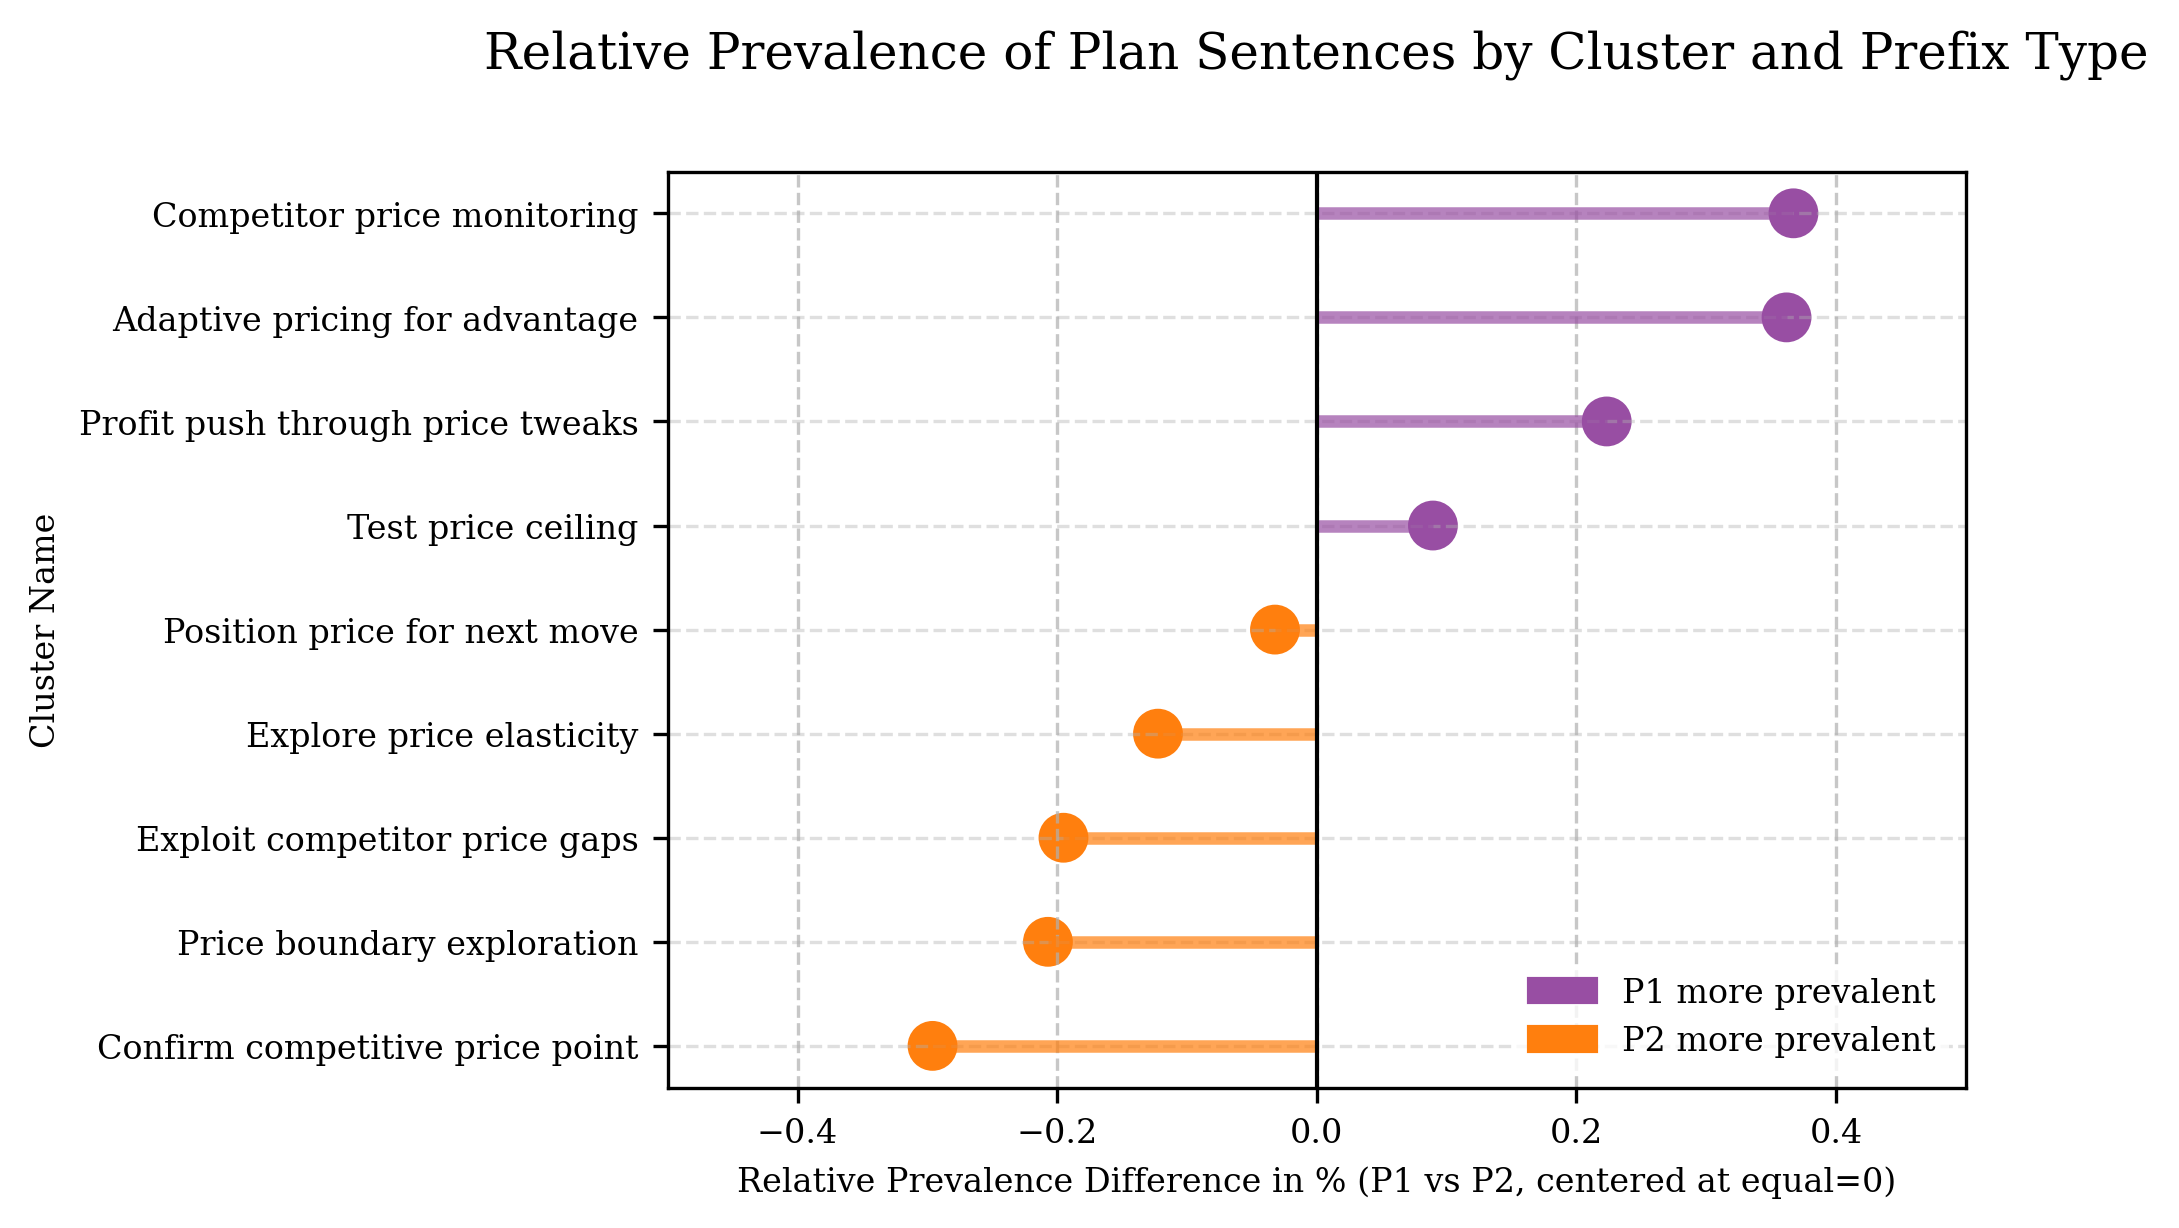

In [ ]:
def plot_results(df, title, save_path):
    # Convert Polars df to pandas
    df = df_cluster_counts.to_pandas()

    # Calculate relative difference centered at zero
    df["relative_diff"] = df["P1_to_P2_ratio"] - 1

    # Define colors based on sign of relative_diff
    df["color"] = np.where(df["relative_diff"] > 0, colors[0], colors[1])

    # Sort by relative_diff for better visualization
    df = df.sort_values("relative_diff")

    plt.figure()

    # Draw horizontal lines from 0 to relative_diff per cluster
    plt.hlines(
        y=df["cluster_name"],
        xmin=0,
        xmax=df["relative_diff"],
        color=df["color"],
        alpha=0.7,
        linewidth=3,
    )

    # Draw dots at the end of the lines
    plt.scatter(df["relative_diff"], df["cluster_name"], color=df["color"], s=120)

    # Vertical line at zero (equal prevalence)
    plt.axvline(0, color="black", linewidth=1)

    # Axis labels and title
    plt.xlabel("Relative Prevalence Difference (P1 vs P2, centered at equal=0)")
    plt.ylabel("Cluster Name")
    plt.title(title, fontsize=SUPTITLE_FONTSIZE, pad=25)

    # Custom legend
    blue_patch = mpatches.Patch(color=colors[0], label="P1 more prevalent")
    orange_patch = mpatches.Patch(color=colors[1], label="P2 more prevalent")
    plt.legend(handles=[blue_patch, orange_patch], loc="lower right")
    # Set x-axis limits
    plt.xlim(-0.5, 0.5)

    plt.grid(axis="x", linestyle="--", alpha=0.7)
    plt.tight_layout()
    plt.savefig(save_path)
    plt.show()


plot_results(
    df_cluster_counts,
    "Relative Prevalence of Plan Sentences by Cluster and Prefix Type",
    OUTPUT_PATH / "text_analysis_relative_prevalence_cluster",
)

In [59]:
import random

random.seed(42)

# Prepare output text
output_lines = []

for k, cluster in cluster_examples.items():
    output_lines.append("=" * 50)
    output_lines.append(f"Cluster: {label_mapping[k].upper()}:")
    output_lines.append("-" * 50)

    # Randomly sample up to 10 sentences from the cluster
    sampled_sentences = random.sample(cluster, min(10, len(cluster)))

    for sentence in sampled_sentences:
        output_lines.append(f"- {sentence}")

    output_lines.append("")  # Empty line between clusters


output_text = "\n".join(output_lines)
print(output_text)

with open(
    OUPUT_TABLES_PATH / "cluster_sentences_random_examples.txt", "w", encoding="utf-8"
) as f:
    f.write(output_text)

Cluster: PRICE BOUNDARY EXPLORATION:
--------------------------------------------------
- Additionally , plan to test a slightly lower price point , such as < PRICE > , to understand the sensitivity of demand to small price decreases .
- Additionally , I will consider testing a price of $ < PRICE > to further explore the sensitivity of demand to minor price increases .
- Additionally , plan to test a slightly lower price , such as $ < PRICE > , to explore the elasticity of demand and potential for increased quantity sold .
- Additionally , briefly test a price at $ < PRICE > to re evaluate the lower boundary of customer willingness to pay and gather more data on market elasticity .
- Additionally , plan to test a lower price , such as $ < PRICE > , to further explore the elasticity of demand and potential for increased quantity sold .
- I plan to test a price of < PRICE > to further explore the upper boundary of customer sensitivity and gather more data on how slight adjustments affect